In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from cell_no_cell import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from guitools import CvRoipolySelector, CvPointSelector

import os
plt.rcParams['image.cmap'] = 'gray'


# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 0
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def get_positions_from_csv(csv_file, frame_idx):
    df = pd.read_csv(csv_file)
    all_cell_positions = df[['X', 'Y']].to_numpy().astype(np.int32)
    all_cell_frame_indices = df[['Slice']].to_numpy().astype(np.int32)
    
    return all_cell_positions[np.where(all_cell_frame_indices == frame_idx)[0]]

Autosave disabled
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
idx = 2
video_OA790_filename = unmarked_labeled_video_OA790_filenames[idx]
csv_cords_filename   = csv_cell_cords_OA790_filenames[idx]
video_OA850_filename = unmarked_video_OA850_filenames[idx]
std_confocal_image_filename = std_confocal_images_for_labeled_OA790[idx]
std_OA850_image_filename = std_OA850_images_for_labeled_OA790[idx]
cell_positions = get_positions_from_csv(csv_cords_filename, frame_idx=1)

print('Files:')
print('------')
print(basename(video_OA790_filename), 
      basename(csv_cords_filename), 
      basename(video_OA850_filename), 
      basename(std_confocal_image_filename),
      basename(std_OA850_image_filename),
      sep='\n')


assert files_of_same_source(video_OA790_filename, csv_cords_filename)
assert files_of_same_source(csv_cords_filename, video_OA850_filename)
assert files_of_same_source(video_OA850_filename, std_OA850_image_filename)
assert files_of_same_source(std_confocal_image_filename, std_OA850_image_filename)

Files:
------
Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped.avi
Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped_cords.csv
Subject3_Session217_OS_(2,0)_1x1_988_OA850nm_dewarped1_extract_reg_cropped.avi
Subject3_Session217_OS_(2,0)_1x1_988_Confocal_dewarped1_extract_reg_std.tif
Subject3_Session217_OS_(2,0)_1x1_988_OA850nm_dewarped1_extract_reg_std.tif


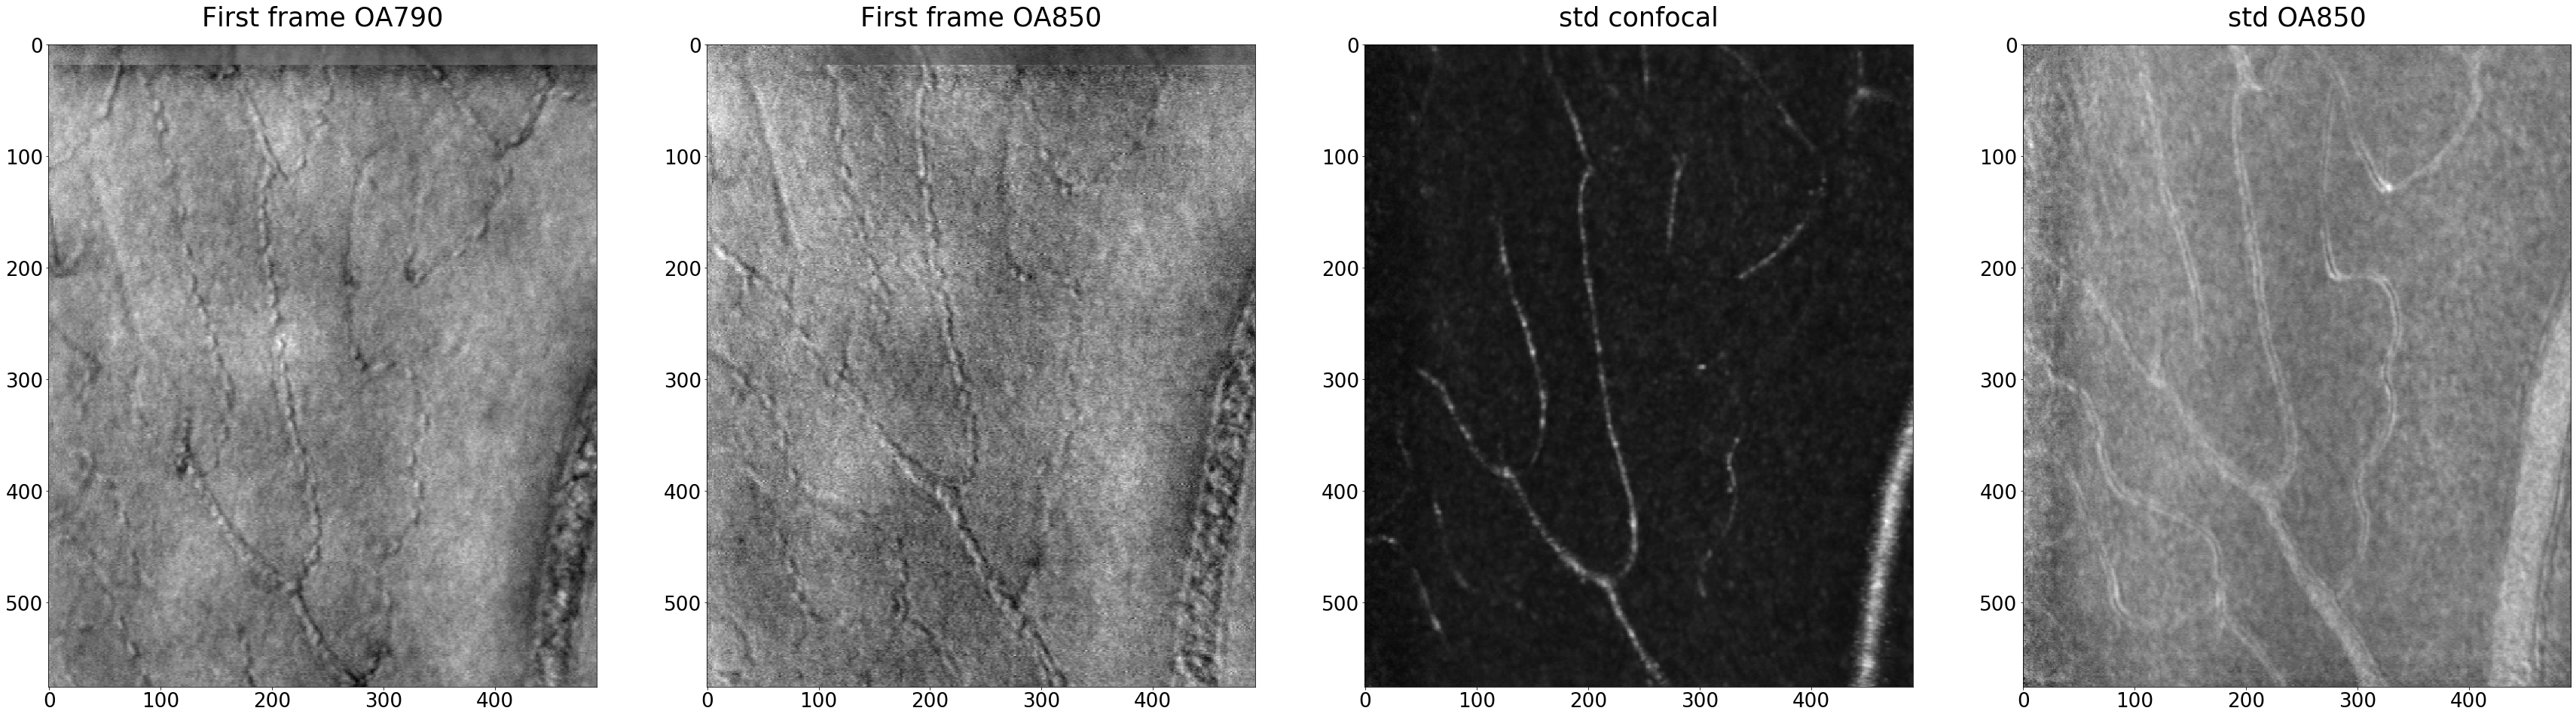

In [3]:
frames_OA790nm = get_frames_from_video(video_OA790_filename)[..., 0]
frames_OA850nm = get_frames_from_video(video_OA850_filename)[..., 0]
std_image_confocal = plt.imread(std_confocal_image_filename)
std_image_OA850 = plt.imread(std_OA850_image_filename)

frame_OA790 = frames_OA790nm[0, ...]
frame_OA850 = frames_OA850nm[0, ...]

fig, axes = plt.subplots(1, 4, figsize=(60, 60))
plt.rcParams['image.cmap'] = 'gray'

axes[0].imshow(frame_OA790)
axes[0].set_title('First frame OA790');
axes[1].imshow(frame_OA850)
axes[1].set_title('First frame OA850')
axes[2].imshow(std_image_confocal)
axes[2].set_title('std confocal')
axes[3].imshow(std_image_OA850)
axes[3].set_title('std OA850');
frame_OA790.shape, frame_OA850.shape;
pass

In [7]:
vessel_mask_OA850 = create_vessel_mask(std_image_OA850,
                                       n_iterations=2,
                                       visualise_intermediate_steps=False)

In [8]:
vessel_mask_confocal = create_vessel_mask(std_image_confocal,
                                          n_iterations=2,
                                          visualise_intermediate_steps=False)

In [9]:
class ImageRegistator(object):
    def __init__(self, source, target):
        self.source = source
        self.target = target
        self.best_dice = dice(source, target)
        self.dices = [self.best_dice]
        self.vertical_displacement = 0
        self.horizontal_displacement = 0
        self.registered_source = source
   
    def register_vertically(self):
        dx = 0
        dys = np.int32(np.arange(1, 200, 1))

        source = self.source
        target = self.target

        # fig, axes = plt.subplots(len(dys), 1, figsize=(100, 100))

        dices = []
        for i, dy in enumerate(dys):
            translation = np.float32([[1, 0, dx], 
                                      [0, 1, dy]])

            height, width = source.shape[:2]

            translated_source = cv2.warpAffine(source, translation, (width, height))
            dice_v = dice(target, translated_source)
            dices.append(dice_v)
        
        # Get displacement that gives best dice coefficient.
        dy = dys[np.argmax(dices)]

        translation = np.float32([[1, 0, dx], 
                                  [0, 1, dy]])
        height, width = source.shape[:2]
        translated_source = cv2.warpAffine(source, translation, (width, height))

        self.registered_source = translated_source
        self.vertical_displacement = dy
        self.best_dice = max(dices)
        self.dices = dices
        
        return self.registered_source
    
    
    def apply_registration(self, im):
        dx, dy = self.horizontal_displacement, self.vertical_displacement

        translation = np.float32([[1, 0, dx], 
                                  [0, 1, dy]])
        height, width = im.shape[:2]
        im = cv2.warpAffine(im, translation, (width, height))
        
        return im
        
    @staticmethod
    def vertical_image_registration(self, source, ):
        dx = 0
        dys = np.int32(np.arange(1, 200, 1))

        source = vessel_mask_OA850
        target = vessel_mask_confocal

        # fig, axes = plt.subplots(len(dys), 1, figsize=(100, 100))

        dices = []
        for i, dy in enumerate(dys):
            translation = np.float32([[1, 0, dx], 
                                      [0, 1, dy]])

            height, width = source.shape[:2]

            translated_source = cv2.warpAffine(source, translation, (width, height))
            dice_v = dice(target, translated_source)
            dices.append(dice_v)
        
        return translated_source, dy

Text(0.5, 1.0, 'Dice: 0.4239178052752085')

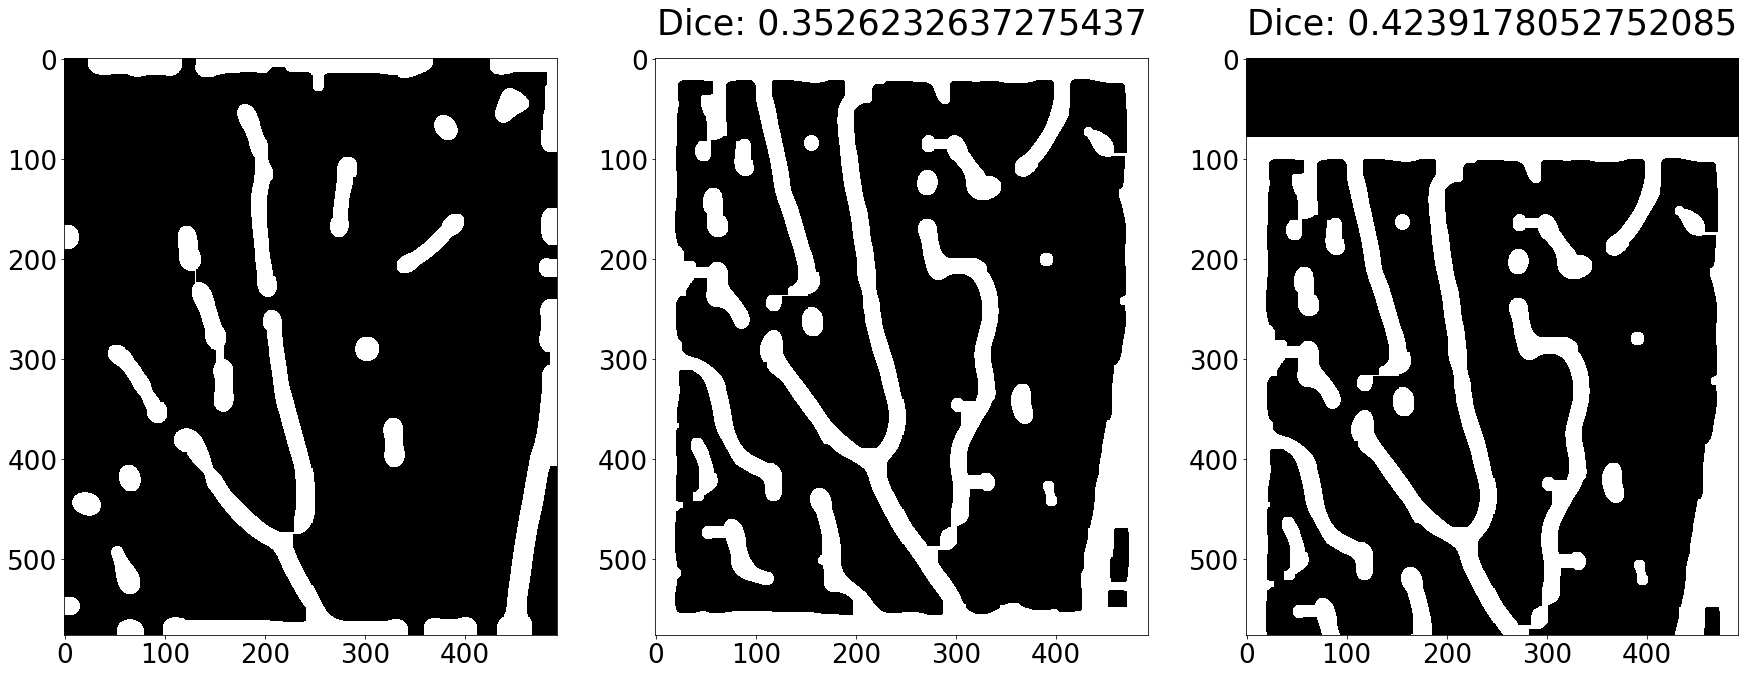

In [10]:
ir = ImageRegistator(source=vessel_mask_OA850, target=vessel_mask_confocal)

fig, axes = plt.subplots(1, 3, figsize=(30, 30))
axes[0].imshow(ir.target)
axes[1].imshow(ir.source)
axes[1].set_title(f'Dice: {ir.best_dice}')
ir.register_vertically()
axes[2].imshow(ir.registered_source)
axes[2].set_title(f'Dice: {ir.best_dice}')

Text(0.5, 1.0, 'Dice: 0.4239178052752085')

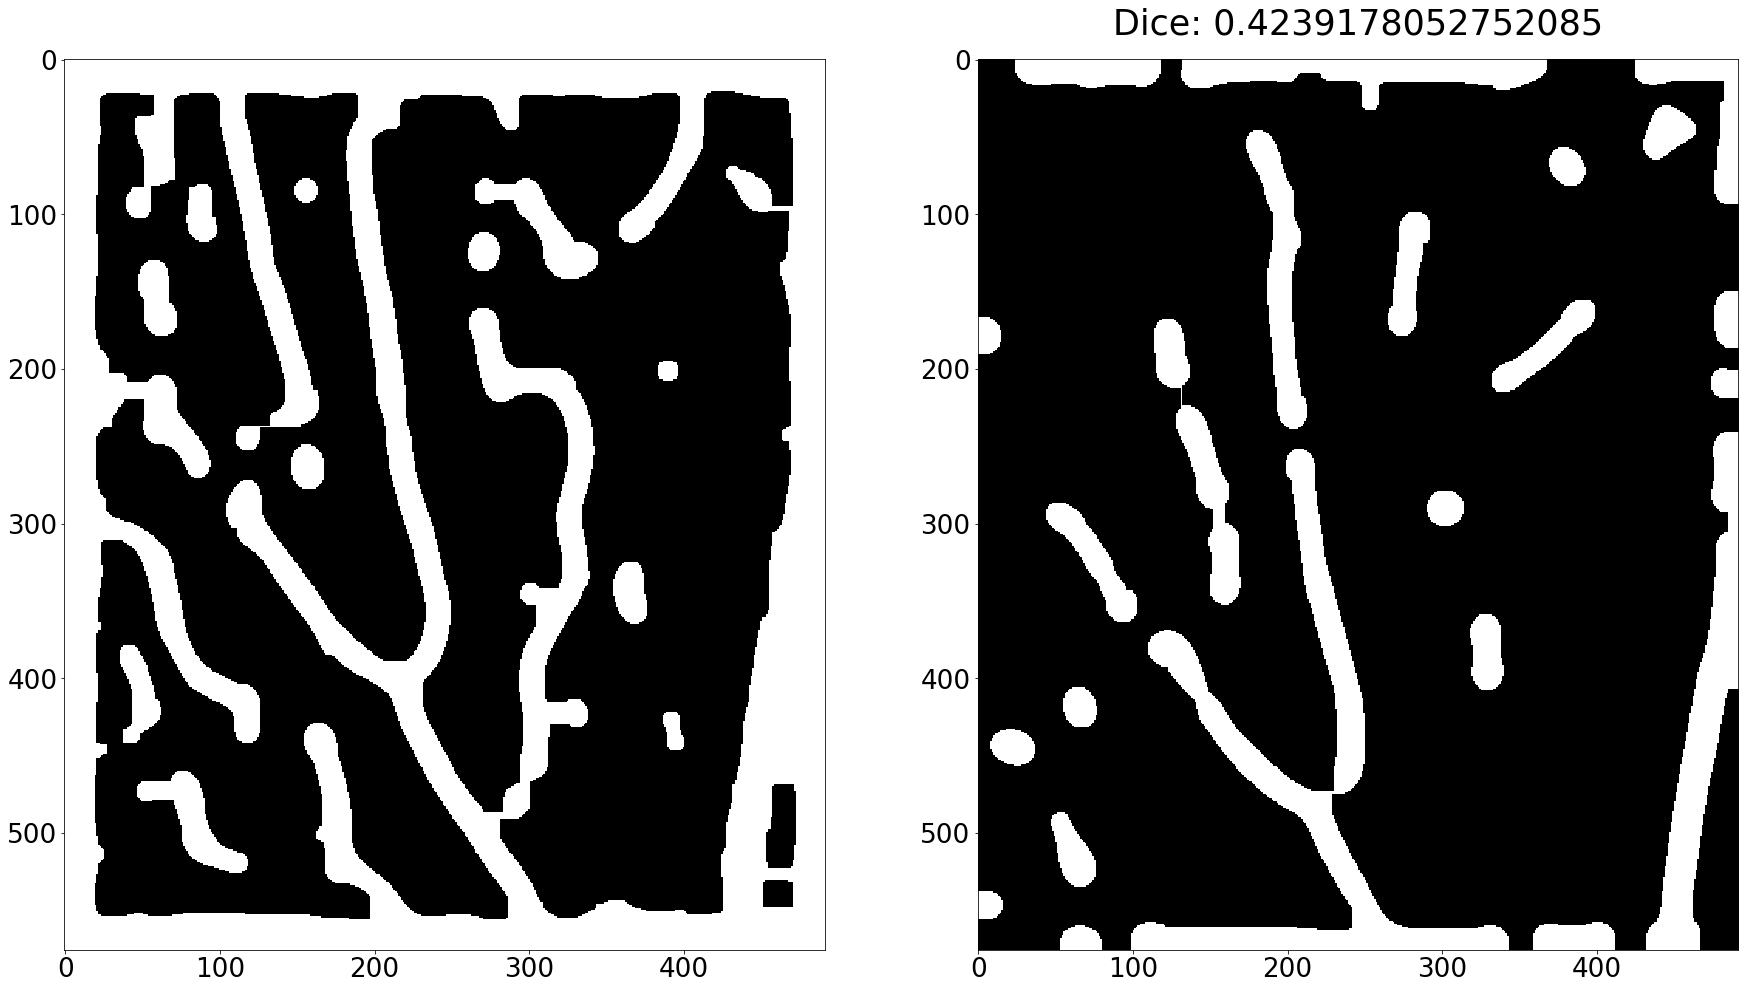

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(30, 30))
axes[0].imshow(vessel_mask_OA850)
axes[1].imshow(vessel_mask_confocal)
axes[1].set_title(f'Dice: {ir.best_dice}')

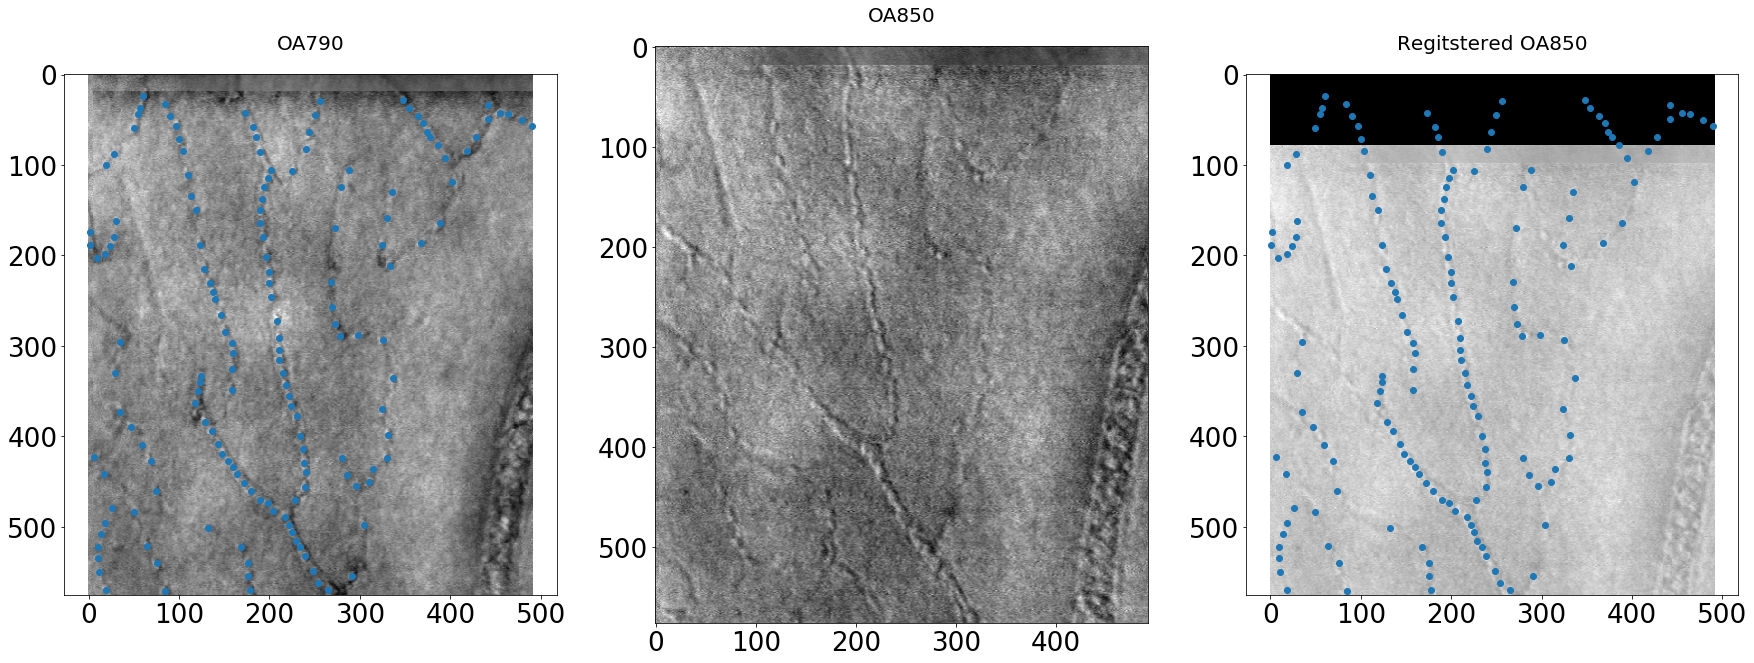

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(30, 30))
plt.rcParams['axes.titlesize'] = '20'

axes[0].imshow(frame_OA790)
axes[0].set_title('OA790')
axes[0].scatter(cell_positions[:, 0], cell_positions[:, 1])
axes[1].imshow(frame_OA850)
axes[1].set_title('OA850')
axes[2].imshow(ir.apply_registration(frame_OA850))
axes[2].set_title('Regitstered OA850')
axes[2].scatter(cell_positions[:, 0], cell_positions[:, 1])

pass

Positions (160, 2)
Positions (160, 2)


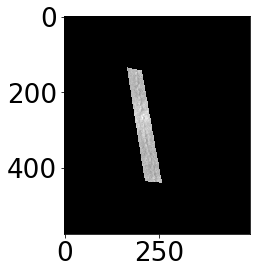

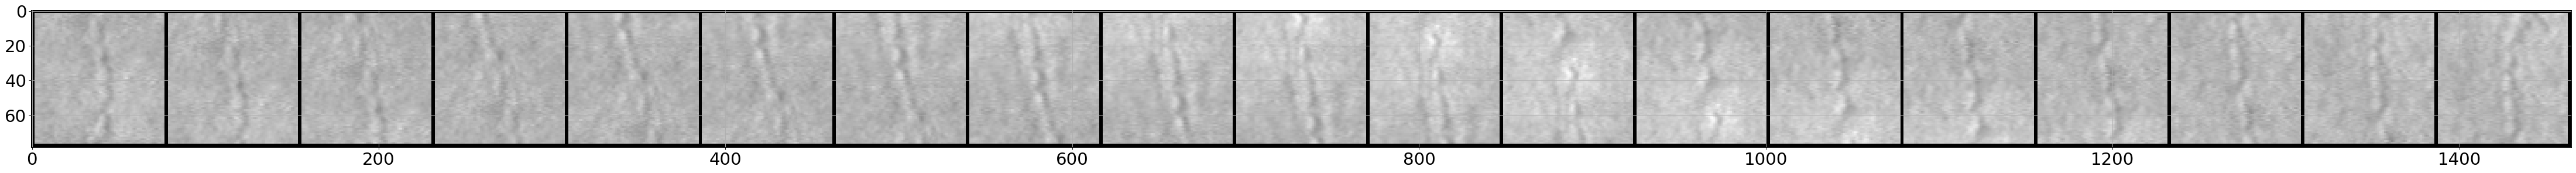

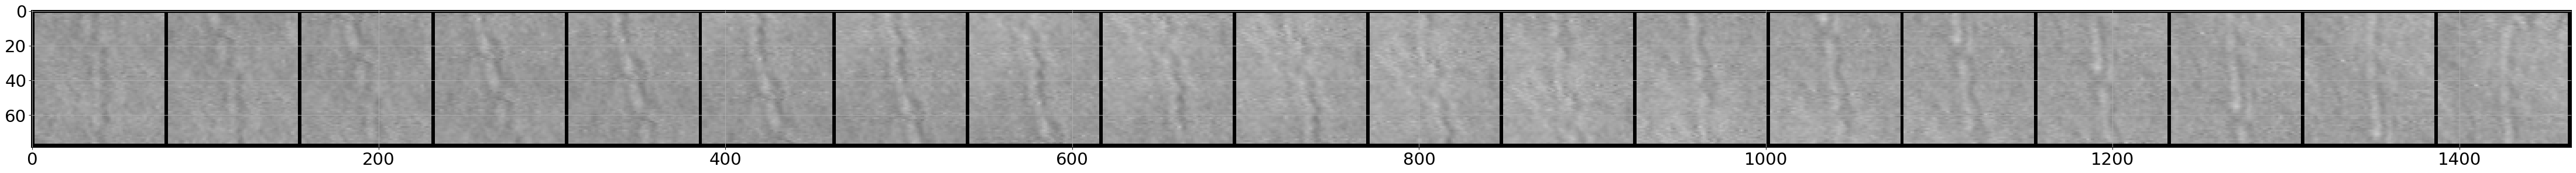

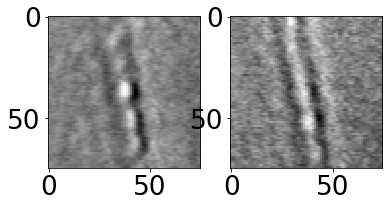

In [150]:
window = 'select segment'
# cv2.imshow(window, frame_OA790)
roipoly_selector = CvRoipolySelector(window, ir.apply_registration(frame_OA850))
roipoly_selector.activate()
selected_vessel_mask = roipoly_selector.mask.copy() 
plt.imshow(frame_OA790 * selected_vessel_mask)

patch_size = (75, 75)
# frame_OA790_marked = plt.imread(marked_video_OA790_filenames[idx])
# cell_patches_OA790_marked = extract_patches_at_positions(frame_OA790_marked, cell_positions, patch_size=patch_size)
cell_patches_OA790 = extract_patches_at_positions(frame_OA790, cell_positions,
                                                  mask=selected_vessel_mask,
                                                  patch_size=patch_size)
cell_patches_OA850 = extract_patches_at_positions(ir.apply_registration(frame_OA850), cell_positions,
                                                  mask=selected_vessel_mask,
                                                  patch_size=patch_size)

# plot_images_as_grid(cell_patches_OA790_marked)
plot_images_as_grid(cell_patches_OA790)
plot_images_as_grid(cell_patches_OA850)

fig, axes = plt.subplots(1, 2)

avg_cell_OA790 = np.average(cell_patches_OA790, axis=0)
avg_cell_OA850 = np.average(cell_patches_OA850, axis=0)


axes[0].imshow(avg_cell_OA790)
axes[1].imshow(avg_cell_OA850)

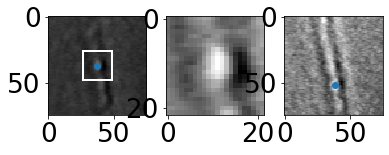

In [151]:
im1 = avg_cell_OA790.copy()
dest_im = avg_cell_OA790.copy()
avg_cell_OA790_clone = avg_cell_OA790.copy()

h, w = avg_cell_OA790.shape
centre_row, centre_col = int(h / 2), int(w / 2)
template_cell = avg_cell_OA790[centre_row - 11:centre_row + 11,
                               centre_col - 11:centre_col + 11]
cv2.rectangle(avg_cell_OA790_clone, (centre_row - 11, centre_col -11),  (centre_row + 11, centre_col + 11), color=(255, 0, 0))

cx, cy = template_matching(np.uint8(template_cell), np.uint8(dest_im))

cx_850, cy_850 = template_matching(np.uint8(template_cell), np.uint8(avg_cell_OA850))

fig, axes = plt.subplots(1, 3)
axes[0].imshow(avg_cell_OA790_clone)
axes[0].scatter(cx, cy)
axes[1].imshow(template_cell)
axes[2].imshow(avg_cell_OA850)
axes[2].scatter(cx_850, cy_850)

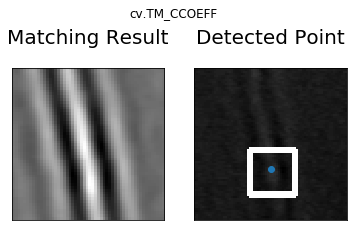

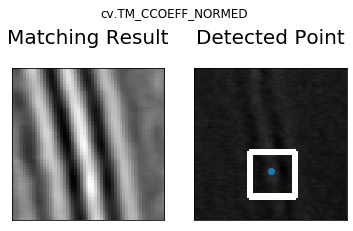

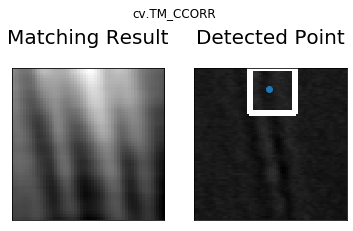

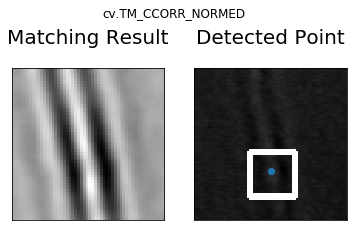

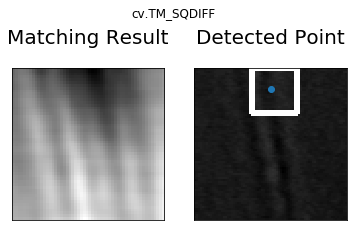

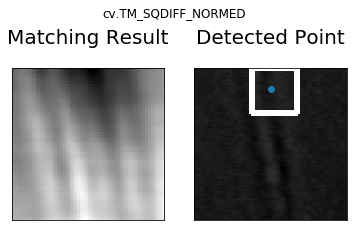

In [152]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = avg_cell_OA850.astype(np.uint8)
img2 = img.copy()
template = template_cell.astype(np.uint8)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    
    y, x = np.unravel_index(np.argmax(img.flatten()), img.shape)  
    y, x = np.array([y, x]) + int(21 / 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.scatter(x, y)
    plt.suptitle(meth)
    plt.show()
pass

In [21]:
from PIL import Image

Image.fromarray(np.round(avg_cell_OA790.astype(np.uint8))).save('avg-cell-OA790.png')
Image.fromarray(np.round(avg_cell_OA850.astype(np.uint8))).save('avg-cell-OA850.png')

9 float32
1 float32


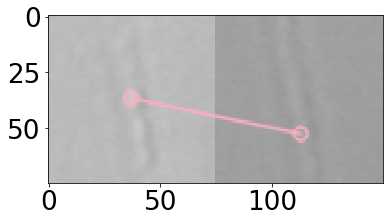

(<matplotlib.image.AxesImage at 0x2d2298e57b8>, None)

In [214]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = np.round(avg_cell_OA790).astype(np.uint8)
img2 = np.round(avg_cell_OA850).astype(np.uint8)

# Initiate ORB detector
surf = cv2.xfeatures2d.SURF_create(40)

# find the keypoints and descriptors with ORB
kp1, des1 = surf.detectAndCompute(img1, None)
kp2, des2 = surf.detectAndCompute(img2, None)
print(len(des1), des1.dtype)
print(len(des2), des2.dtype)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:1],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()


In [174]:
matches[1]


<DMatch 000002D223F1ECB0>

In [229]:
def match_template(image, template, method=cv2.TM_CCOEFF_NORMED):
    template = template.copy()
    image = image.copy()
    
    template_w, template_h = template.shape
    res = cv2.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    cx, cy  = (np.floor(top_left[0] + template_w / 2), np.floor(top_left[1] + template_h / 2))
    
    return (cx, cy)


def find_bloodcell_correspondance(im_790, im_850, method='template_match'):
    template_matching_methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
                                 cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, 
                                 'template_match']
    feature_matching_methods = ['surf']
    if method in template_matching_methods:
        if method is 'template_match':
            # default template matching method is cross corellation
            method = cv2.TM_CCORR_NORMED
            
        h, w = im_790.shape
        centre_row, centre_col = int(h / 2), int(w / 2)
        template_cell = im_790[centre_row - 11:centre_row + 11,
                               centre_col - 11:centre_col + 11]
        matched_x, matched_y = template_matching(np.uint8(template_cell), np.uint8(im_850))
    elif method in feature_matching_methods:
        if method is 'surf':
            im_790 = np.uint8(im_790)
            im_890 = np.uint8(im_850)
            for i in range(400, 0, -10):
                print(i)
                # Initiate ORB detector
                surf = cv2.xfeatures2d.SURF_create(i)

                # find the keypoints and descriptors with ORB
                kp1, des1 = surf.detectAndCompute(im_790, None)
                kp2, des2 = surf.detectAndCompute(im_890, None)
                    
                if des1 is None or des2 is None or len(kp1) is 0 or len(kp2) is 0:
                    print('cont', i)
                    continue
                    
                # create BFMatcher object
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                # Match descriptors.
                matches = bf.match(des1, des2)
                
                if len(matches) is 0:
                    continue
                # Sort them in the order of their distance.
                matches = sorted(matches, key = lambda x:x.distance)
                # Draw first match
                match = matches[0]
                img1_idx = match.queryIdx
                img2_idx = match.trainIdx

                # x - columns
                # y - rows
                # Get the coordinates
                x1, y1 = kp1[img1_idx].pt
                matched_x, matched_y = kp2[img2_idx].pt
                break
    else:
        raise Exception(f'No such method {method} for bloodcell correspondance.\n Use one of {template_matching_methods.extend(feature_matching_methods)}')
    print(method)
    return matched_x, matched_y

4


5


2


3


0


1


400
cont 400
390
cont 390
380
cont 380
370
cont 370
360
cont 360
350
cont 350
340
cont 340
330
cont 330
320
cont 320
310
cont 310
300
cont 300
290
cont 290
280
cont 280
270
cont 270
260
cont 260
250
cont 250
240
cont 240
230
cont 230
220
cont 220
210
cont 210
200
cont 200
190
cont 190
180
cont 180
170
cont 170
160
cont 160
150
cont 150
140
cont 140
130
cont 130
120
cont 120
110
cont 110
100
surf


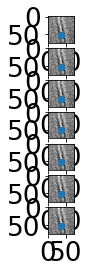

In [230]:
methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
           cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, 'surf']

fig ,axes = plt.subplots(len(methods))

for ax, method in zip(axes, methods):
    x, y = find_bloodcell_correspondance(avg_cell_OA790, avg_cell_OA850, method)
    ax.imshow(avg_cell_OA850)
    ax.scatter(x, y)
    pass